In [86]:
#pip install pandas numpy matplotlib seaborn

In [87]:
# 2. Importación de Librerías.
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from datetime import datetime

In [88]:
# 3. Definición de Constantes.
DB_FILENAME = 'gestion_produccion.db'

# 4. Configuración de Rutas.
try:
    # __file__ no está definido en notebooks, por lo que se usa os.getcwd() como alternativa.
    PROJECT_ROOT = os.path.dirname(os.path.abspath(__file__))
except NameError:
    PROJECT_ROOT = os.getcwd()

DB_PATH = os.path.join(PROJECT_ROOT, DB_FILENAME)

In [89]:
# 5. Carga de Datos en Variables Individuales.
print(f"Intentando conectar a la base de datos en: {DB_PATH}")
conn = None
try:
    conn = sqlite3.connect(DB_PATH)
    
    # Cargar cada tabla en un DataFrame específico.
    producto_df = pd.read_sql_query('SELECT * FROM producto', conn)
    print(f"Tabla 'producto' cargada en producto_df con {len(producto_df)} filas.")
    
    lote_df = pd.read_sql_query('SELECT * FROM lote', conn)
    print(f"Tabla 'lote' cargada en lote_df con {len(lote_df)} filas.")
    
    rol_df = pd.read_sql_query('SELECT * FROM rol', conn)
    print(f"Tabla 'rol' cargada en rol_df con {len(rol_df)} filas.")
    
    empleado_df = pd.read_sql_query('SELECT * FROM empleado', conn)
    print(f"Tabla 'empleado' cargada en empleado_df con {len(empleado_df)} filas.")

    produccion_df = pd.read_sql_query('SELECT * FROM produccion', conn)
    print(f"Tabla 'produccion' cargada en produccion_df con {len(produccion_df)} filas.")

    cliente_df = pd.read_sql_query('SELECT * FROM cliente', conn)
    print(f"Tabla 'cliente' cargada en cliente_df con {len(cliente_df)} filas.")

    venta_df = pd.read_sql_query('SELECT * FROM venta', conn)
    print(f"Tabla 'venta' cargada en venta_df con {len(venta_df)} filas.")

    asistencia_df = pd.read_sql_query('SELECT * FROM asistencia', conn)
    print(f"Tabla 'asistencia' cargada en asistencia_df con {len(asistencia_df)} filas.")

except sqlite3.Error as e:
    print(f"Error al conectar o leer la base de datos: {e}", file=sys.stderr)
finally:
    if conn:
        conn.close()

Intentando conectar a la base de datos en: c:\Users\Julian Waksmann\Documents\03 UNIVERSIDAD\labo\gestion_produccion.db
Tabla 'producto' cargada en producto_df con 10 filas.
Tabla 'lote' cargada en lote_df con 3875 filas.
Tabla 'rol' cargada en rol_df con 3 filas.
Tabla 'empleado' cargada en empleado_df con 16 filas.
Tabla 'produccion' cargada en produccion_df con 3875 filas.
Tabla 'cliente' cargada en cliente_df con 40 filas.
Tabla 'venta' cargada en venta_df con 11725 filas.
Tabla 'asistencia' cargada en asistencia_df con 7522 filas.


In [90]:
# Pre-procesamiento y Conversión de Tipos de Datos

# Se convierte la columna 'fecha_vto' del DataFrame de lotes.
lote_df['fecha_vto'] = pd.to_datetime(lote_df['fecha_vto'])

# Se convierte la columna 'fecha' del DataFrame de asistencia.
asistencia_df['fecha'] = pd.to_datetime(asistencia_df['fecha'])

print("Columnas de fecha convertidas a formato datetime exitosamente.")

Columnas de fecha convertidas a formato datetime exitosamente.


# Título: Análisis de Desperdicios por Vencimiento

--- Valor Total Desperdiciado por Producto ---
nombre
Alfajor de maicena    2296.5
Name: valor_desperdiciado, dtype: float64


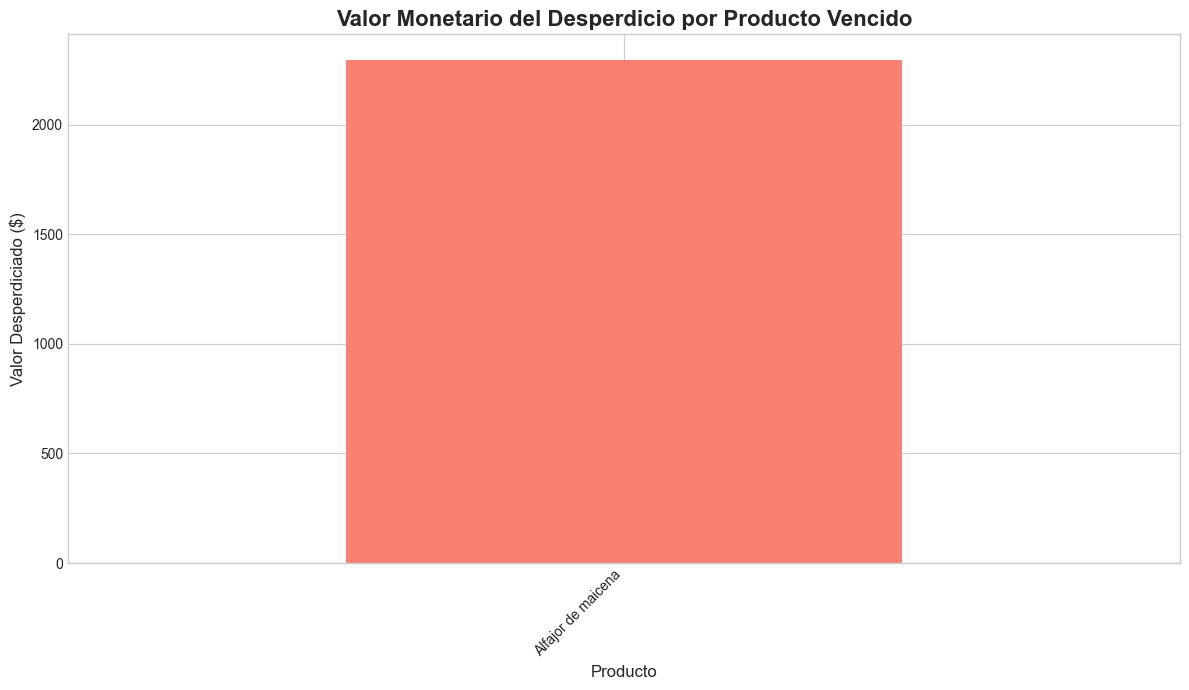

In [91]:
# 1. Definición de Constantes
# Se define la fecha de referencia para el análisis. Cualquier lote con fecha de
# vencimiento anterior a esta se considerará expirado.
FECHA_ANALISIS = datetime.now()

# 2. Identificación de Lotes Vencidos con Stock
# Se filtra el DataFrame de lotes para encontrar filas que cumplan ambas condiciones:
# a) La fecha de vencimiento es anterior a la fecha de análisis.
# b) La cantidad de inventario restante es mayor que cero.
lotes_vencidos_df = lote_df[(lote_df['fecha_vto'] < FECHA_ANALISIS) & (lote_df['cantidad'] > 0)].copy()

# 3. Cálculo del Valor del Desperdicio
# Se une el DataFrame de lotes vencidos con el de productos para acceder al precio de cada uno.
desperdicio_df = pd.merge(lotes_vencidos_df, producto_df, on='id_producto', how='left')

# Se calcula una nueva columna 'valor_desperdiciado'.
desperdicio_df['valor_desperdiciado'] = desperdicio_df['cantidad'] * desperdicio_df['precio']

# 4. Agregación de Resultados por Producto
# Se agrupan los datos por nombre de producto para sumar el valor total desperdiciado por cada uno.
desperdicio_por_producto = desperdicio_df.groupby('nombre')['valor_desperdiciado'].sum().sort_values(ascending=False)

print("--- Valor Total Desperdiciado por Producto ---")
if not desperdicio_por_producto.empty:
    print(desperdicio_por_producto)
else:
    print("No se encontraron lotes vencidos con stock remanente.")

# 5. Visualización de Resultados
if not desperdicio_por_producto.empty:
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))
    
    desperdicio_por_producto.plot(kind='bar', color='salmon')
    
    plt.title('Valor Monetario del Desperdicio por Producto Vencido', fontsize=16, weight='bold')
    plt.xlabel('Producto', fontsize=12)
    plt.ylabel('Valor Desperdiciado ($)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

--- Análisis de Puntualidad por Empleado para el Mes 6/2025 ---
                  promedio_retraso_min  total_llegadas_tarde
nombre                                                      
Sofia Diaz                    1.666667                     2
Ana Fernandez                 0.800000                     1
Carlos Gomez                  0.000000                     0
Camila Benitez                0.000000                     0
Florencia Ortiz               0.000000                     0
Javier Ramirez                0.000000                     0
Juan Perez                    0.000000                     0
Diego Lopez                   0.000000                     0
Laura Sanchez                 0.000000                     0
Lucia Torres                  0.000000                     0
Martin Gonzalez               0.000000                     0
Maria Rodriguez               0.000000                     0
Matias Acosta                 0.000000                     0
Pedro Martinez       

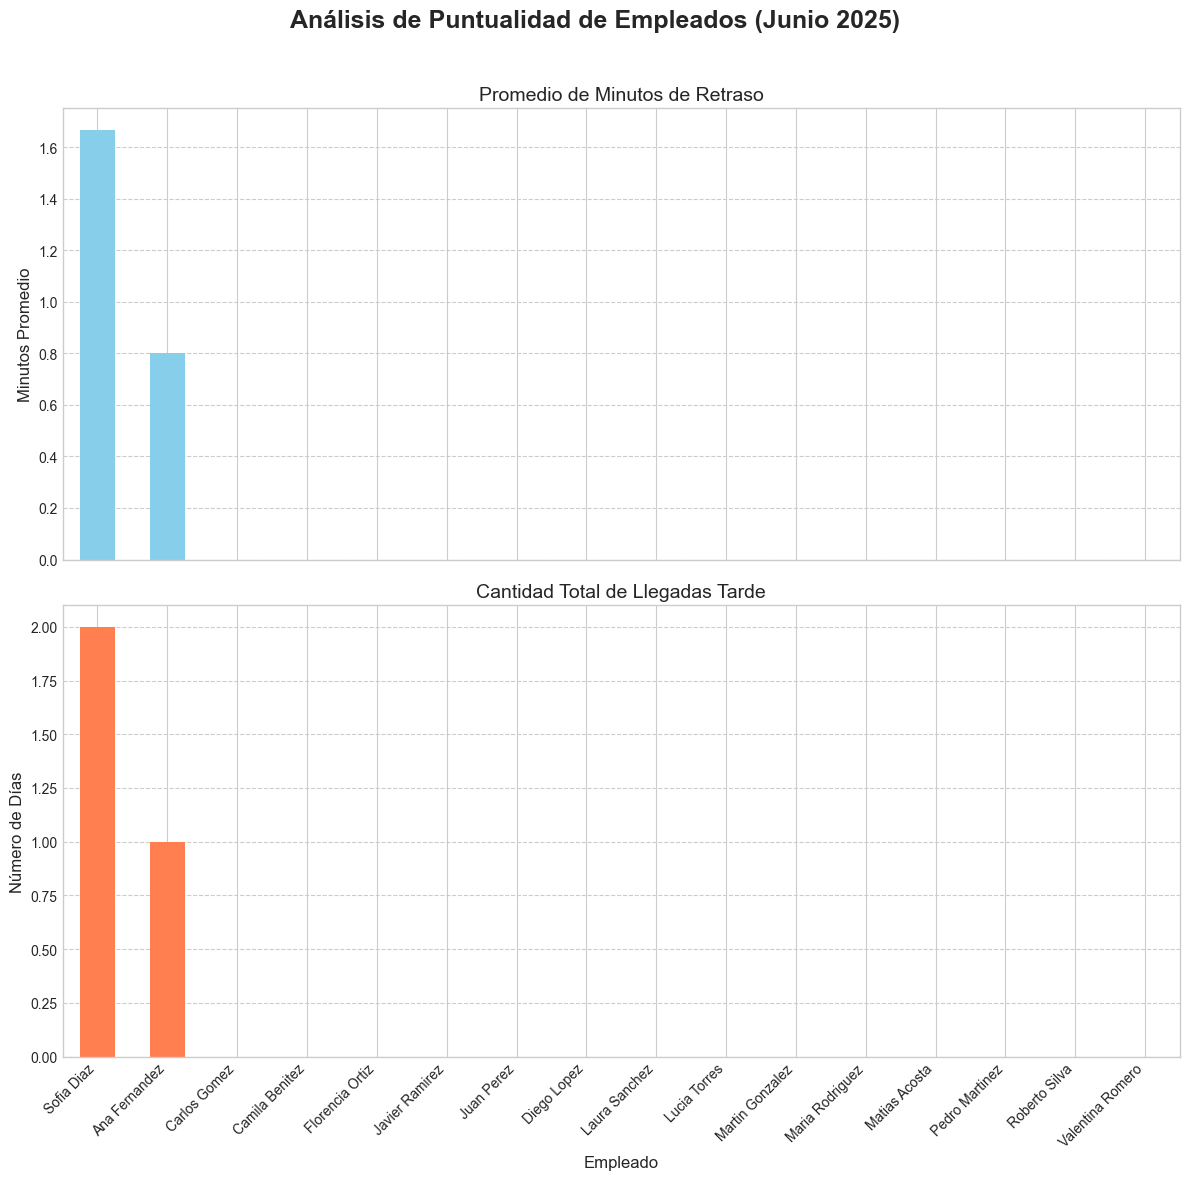

In [92]:
# 1. Definición de Constantes
HORA_ENTRADA = 8      # Hora de entrada oficial: 8:00 AM.
MES_ANALISIS = 6      # Mes a analizar: 6 (Junio).
ANO_ANALISIS = 2025   # Año de la simulación.

# 2. Filtrado de Datos por Mes
# Se filtran los registros de asistencia para incluir solo el mes y año de interés.
asistencia_mes_df = asistencia_df[
    (asistencia_df['fecha'].dt.month == MES_ANALISIS) &
    (asistencia_df['fecha'].dt.year == ANO_ANALISIS)
].copy()

# 3. Preparación de Datos de Entrada
# Se filtran únicamente los registros de 'entrada' del DataFrame ya filtrado por mes.
entradas_df = asistencia_mes_df[asistencia_mes_df['tipo'] == 'entrada'].copy()

# 4. Cálculo de Retraso
# Se calcula la diferencia en minutos entre la hora de entrada real y la hora oficial.
entradas_df['retraso_min'] = (
    (entradas_df['fecha'] - entradas_df['fecha'].dt.normalize().add(pd.Timedelta(hours=HORA_ENTRADA)))
    .dt.total_seconds() / 60
).apply(lambda x: max(0, x))

# 5. Enriquecimiento de Datos
# Se une el DataFrame de entradas con el de empleados para obtener los nombres.
asistencia_con_nombre_df = pd.merge(entradas_df, empleado_df, on='id_empleado', how='left')

# 6. Agregación de Métricas por Empleado
# Se agrupan los datos por nombre de empleado para calcular las métricas de puntualidad del mes.
analisis_puntualidad = asistencia_con_nombre_df.groupby('nombre').agg(
    promedio_retraso_min=('retraso_min', 'mean'),
    total_llegadas_tarde=('retraso_min', lambda x: (x > 0).sum())
).sort_values(by='total_llegadas_tarde', ascending=False)

print(f"--- Análisis de Puntualidad por Empleado para el Mes {MES_ANALISIS}/{ANO_ANALISIS} ---")
print(analisis_puntualidad)

# 7. Visualización de Resultados
if not analisis_puntualidad.empty:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
    fig.suptitle(f'Análisis de Puntualidad de Empleados (Junio {ANO_ANALISIS})', fontsize=18, weight='bold')

    # Gráfico de Retraso Promedio
    analisis_puntualidad['promedio_retraso_min'].plot(kind='bar', ax=ax1, color='skyblue')
    ax1.set_title('Promedio de Minutos de Retraso', fontsize=14)
    ax1.set_ylabel('Minutos Promedio', fontsize=12)
    ax1.grid(axis='y', linestyle='--')

    # Gráfico de Cantidad de Llegadas Tarde
    analisis_puntualidad['total_llegadas_tarde'].plot(kind='bar', ax=ax2, color='coral')
    ax2.set_title('Cantidad Total de Llegadas Tarde', fontsize=14)
    ax2.set_xlabel('Empleado', fontsize=12)
    ax2.set_ylabel('Número de Días', fontsize=12)
    ax2.grid(axis='y', linestyle='--')

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print(f"No se encontraron datos de asistencia para el mes {MES_ANALISIS}/{ANO_ANALISIS}.")

--- Porcentaje de Merma Promedio por Producto ---
nombre
Premezcla para pizza             30.218942
Alfajor de maicena               26.014064
Bizcochos de grasa               23.506008
Yogur bebible de frutilla        20.126754
Galletitas de avena              19.438267
Barra de cereal con chocolate    16.602626
Muffins de arandanos             12.164566
Tostadas de arroz                11.413104
Grisines con sesamo              10.737967
Budin de limon                   10.387106
Name: porcentaje_merma, dtype: float64


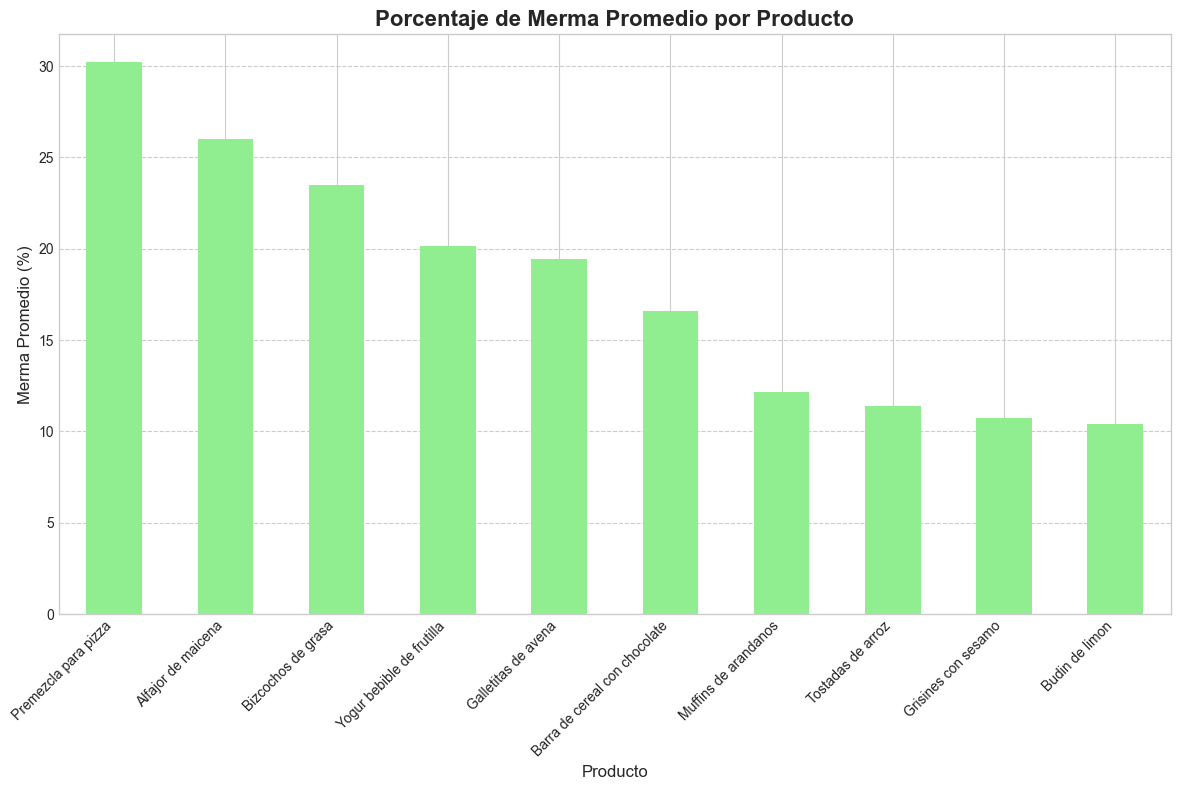

In [93]:
# 1. Enriquecimiento de Datos de Producción
# Se une el DataFrame de producción con el estado final de los lotes para obtener la cantidad remanente.
produccion_lotes_df = pd.merge(produccion_df, lote_df, on='id_lote', how='left')

# Se añade la información de los productos para poder agrupar por nombre.
produccion_completa_df = pd.merge(produccion_lotes_df, producto_df, on='id_producto', how='left')

# 2. Cálculo de Merma por Lote
# Se calcula el porcentaje de merma, que es la proporción del lote que no se vendió.
# Se usa np.where para evitar divisiones por cero si un lote se creó con cantidad_out = 0.
produccion_completa_df['porcentaje_merma'] = np.where(
    produccion_completa_df['cantidad_out'] > 0,
    (produccion_completa_df['cantidad'] / produccion_completa_df['cantidad_out']) * 100,
    0
)

# 3. Agregación de Métricas por Producto
# Se calcula el promedio de merma para cada producto.
merma_por_producto = produccion_completa_df.groupby('nombre')['porcentaje_merma'].mean().sort_values(ascending=False)

print("--- Porcentaje de Merma Promedio por Producto ---")
print(merma_por_producto)

# 4. Visualización de Resultados
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))

merma_por_producto.plot(kind='bar', color='lightgreen')

plt.title('Porcentaje de Merma Promedio por Producto', fontsize=16, weight='bold')
plt.xlabel('Producto', fontsize=12)
plt.ylabel('Merma Promedio (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()